# Chapter 17: Regression-based Forecasting

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
from pathlib import Path

import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

import dmba

%matplotlib inline


no display found. Using non-interactive Agg backend


## Figure 17.1

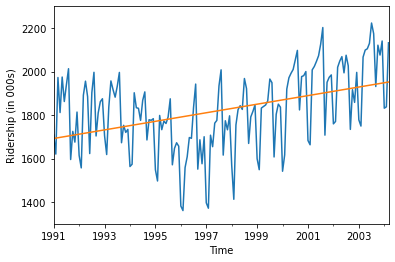

In [2]:
# load data and convert to time series
Amtrak_df = dmba.load_data('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# fit a linear trend model to the time series 
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()

# plot the time series
ax = ridership_ts.plot()
ridership_lm.predict(ridership_df).plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
plt.show()

In [3]:
ridership_df.head()

,Ridership,const,trend
Date,,,
1991-01-01,1708.917,1.0,1.0
1991-02-01,1620.586,1.0,2.0
1991-03-01,1972.715,1.0,3.0
1991-04-01,1811.665,1.0,4.0
1991-05-01,1974.964,1.0,5.0


## Figure 17.2

In [4]:
nValid = 36
nTrain = len(ridership_ts) - nValid

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

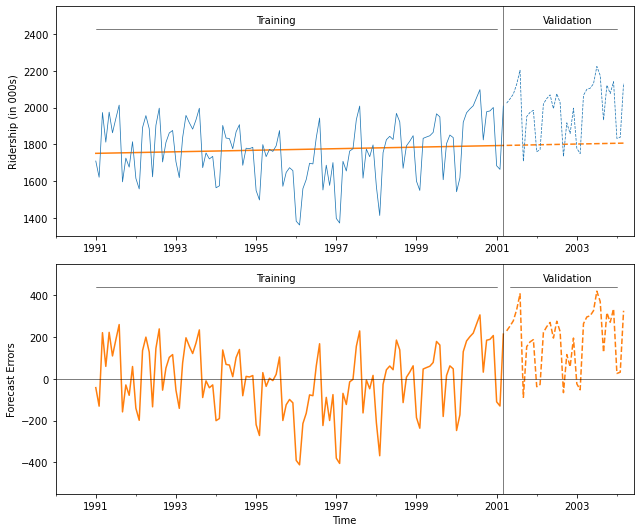

In [5]:
# Fit linear model using training set and predict on validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)

# Create the graph
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()
    # ensure that both axes have the same x-range
    xlim = (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), 
            max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
    axes[0].set_xlim(*xlim)
    axes[1].set_xlim(*xlim)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)

plt.tight_layout()
plt.show()

## Table 17.2

In [6]:
print(ridership_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Thu, 27 May 2021   Prob (F-statistic):              0.390
Time:                        20:03:39   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.073     60.206      0.0

## Exponential Trend

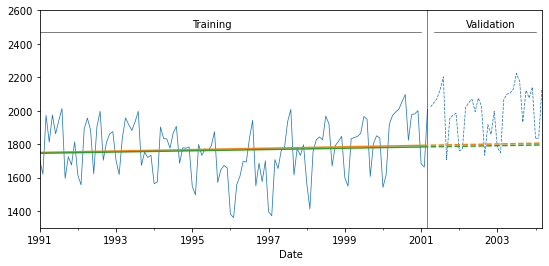

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(Ridership)   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5707
Date:                Thu, 27 May 2021   Prob (F-statistic):              0.451
Time:                        20:03:39   Log-Likelihood:                 118.67
No. Observations:                 123   AIC:                            -233.3
Df Residuals:                     121   BIC:                            -227.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4647      0.017    442.535      0.000       7.431       7.498
trend          0.0002      0.000      0.755      0.451      -0.000       0.001
==============================================================================
Omnibus:                        8.566   Durbin-Watson:                   1.106
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.749
Skew:                          -0.652   Prob(JB):                       0.0126
Kurtosis:                       3.091   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
ridership_lm_linear = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df_linear = ridership_lm_linear.predict(valid_df)

ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
predict_df_expo = ridership_lm_expo.predict(valid_df)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,4))
train_df.plot(y='Ridership', ax=ax, color='C0', linewidth=0.75)
valid_df.plot(y='Ridership', ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
singleGraphLayout(ax, [1300, 2600], train_df, valid_df)
ridership_lm_linear.predict(train_df).plot(color='C1')
ridership_lm_linear.predict(valid_df).plot(color='C1', linestyle='dashed')
ridership_lm_expo.predict(train_df).apply(lambda row: math.exp(row)).plot(color='C2')
ridership_lm_expo.predict(valid_df).apply(lambda row: math.exp(row)).plot(color='C2', 
                                                                          linestyle='dashed')

ax.get_legend().remove()

plt.show()
ridership_lm_expo.summary()

## Figure 17.4

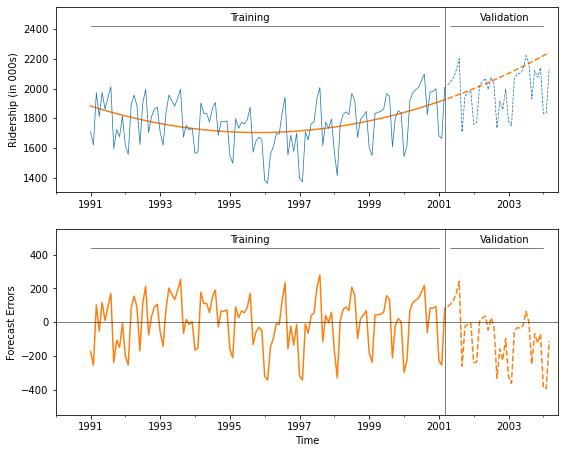

In [8]:
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_poly.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_poly.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_poly.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_poly.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)


plt.show()

## Table 17.5

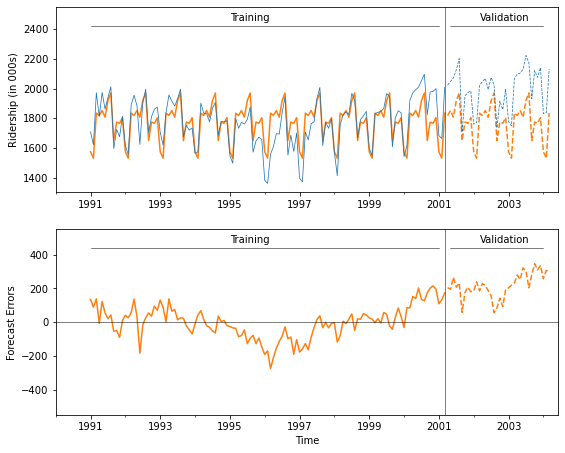

In [9]:
ridership_df = tsatools.add_trend(ridership_ts, trend='c')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_season.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_season.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_season.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()

In [10]:
print(ridership_lm_season.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     17.54
Date:                Thu, 27 May 2021   Prob (F-statistic):           1.20e-19
Time:                        20:03:40   Log-Likelihood:                -736.38
No. Observations:                 123   AIC:                             1497.
Df Residuals:                     111   BIC:                             1531.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1573.9722     30.578     51.

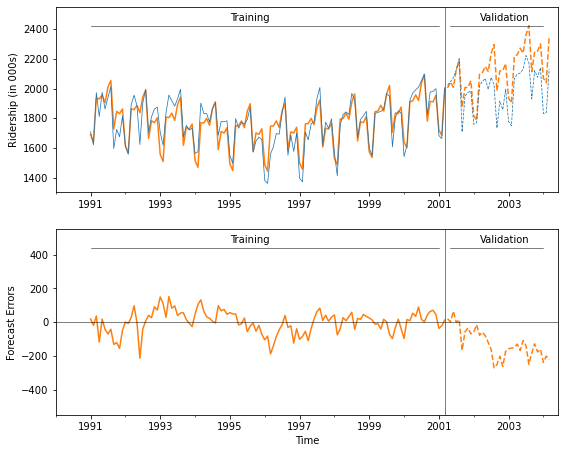

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Thu, 27 May 2021   Prob (F-statistic):           3.75e-35
Time:                        20:03:41   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

In [11]:
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_trendseason = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_trendseason.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_trendseason.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()
print(ridership_lm_trendseason.summary())

## Figure 17.7

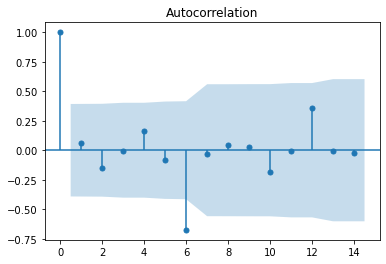

[ 1.00000000e+00  6.35437842e-02 -1.49498748e-01 -3.02952532e-03
  1.65998491e-01 -8.59840878e-02 -6.75578620e-01 -2.82741268e-02
  4.54455641e-02  2.44855546e-02 -1.82791170e-01 -4.00188369e-03
  3.55455309e-01 -4.33122713e-03 -2.73382412e-02 -5.48434679e-02
  1.48262818e-01  5.09943126e-02 -1.28619883e-01  1.66932807e-02
  3.79646645e-03  2.10553074e-04 -7.42058354e-02  2.38580903e-02
  1.97525933e-02]


In [12]:
tsaplots.plot_acf(train_df['1991-01-01':'1993-01-01'].Ridership)
plt.show()
print(stattools.acf(train_df['1991-01-01':'1993-01-01'].Ridership, nlags=24, fft=True))

## Figure 17.8

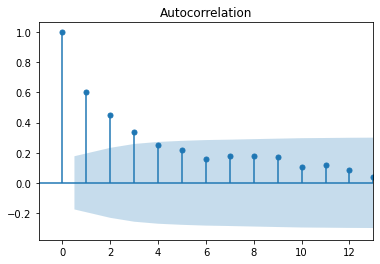

[ 1.          0.60405883  0.44983171  0.3373083   0.25329034  0.21565844
  0.15901326  0.17676683  0.17553762  0.17140882  0.10739472  0.11976519
  0.08512942  0.03621337 -0.04100296 -0.10220097 -0.08359282 -0.10871958
 -0.13125876 -0.19609773 -0.18755508 -0.17909437 -0.12700313 -0.06082369
 -0.17881149 -0.16108249 -0.19865283 -0.22465493 -0.19063245 -0.14932752
 -0.17833501 -0.18558963 -0.18364622 -0.18812853 -0.15001921 -0.19938667
 -0.24784616 -0.20621591 -0.19947185 -0.1780327  -0.09340723]


In [13]:
residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
tsaplots.plot_acf(residual)
plt.xlim(-1, 13)
plt.show()
print(stattools.acf(residual, nlags=40, fft=True))

## Table 17.7

In [14]:
formula = 'Ridership ~ trend + np.square(trend) + C(Month)'
train_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

train_res_arima = ARIMA(train_lm_trendseason.resid, order=(1, 0, 0), freq='MS').fit(trend='nc', disp=0)
forecast, _, conf_int = train_res_arima.forecast(1)

print(train_res_arima.summary())
print(pd.DataFrame({'coef': train_res_arima.params, 'std err': train_res_arima.bse}))

print(forecast)
print('Forecast {0:.3f} [{1[0][0]:.3f}, {1[0][1]:.3f}]'.format(forecast, conf_int))

print(train_lm_trendseason.resid[-1])

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  123
Model:                     ARMA(1, 0)   Log Likelihood                -663.542
Method:                       css-mle   S.D. of innovations             53.192
Date:                Thu, 27 May 2021   AIC                           1331.084
Time:                        20:03:41   BIC                           1336.709
Sample:                    01-01-1991   HQIC                          1333.369
                         - 03-01-2001                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5998      0.071      8.416      0.000       0.460       0.739
                                    Roots                                    
                  Real          Imaginary           M

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [15]:
print(ridership_lm_trendseason.predict(valid_df).head(), valid_df.head())

Date
2001-04-01    2004.270893
2001-05-01    2045.419400
2001-06-01    2008.675207
2001-07-01    2128.560114
2001-08-01    2187.911321
dtype: float64             Ridership  const  trend  Month
Date                                      
2001-04-01   2023.792    1.0  124.0      4
2001-05-01   2047.008    1.0  125.0      5
2001-06-01   2072.913    1.0  126.0      6
2001-07-01   2126.717    1.0  127.0      7
2001-08-01   2202.638    1.0  128.0      8


In [16]:
# train_ridership_arima = ARIMA(train_df.Ridership, order=(10, 0, 0), freq='MS').fit()
# forecast, _, conf_int = train_ridership_arima.forecast(1)
# print(pd.DataFrame({'coef': train_ridership_arima.params, 'std err': train_ridership_arima.bse}))
# print('Forecast {0[0]:.3f} [{1[0][0]:.3f}, {1[0][1]:.3f}]'.format(forecast, conf_int))

# # print(train_lm_trendseason.resid[-1])
# ax = train_df.Ridership.plot(figsize=(9,4))
# train_ridership_arima.fittedvalues.plot(ax=ax)
# singleGraphLayout(ax, [1300, 2550], train_df, valid_df)
# valid_df.Ridership.plot(ax=ax)

# forecast = pd.Series(train_ridership_arima.forecast(len(valid_df))[0], index=valid_df.index)
# forecast.plot(ax=ax)
# plt.show()


## Figure 17.9

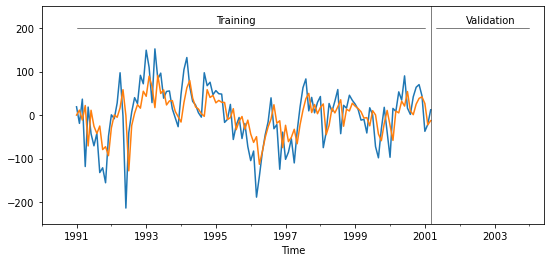

In [17]:
ax = train_lm_trendseason.resid.plot(figsize=(9,4))
train_res_arima.fittedvalues.plot(ax=ax)
singleGraphLayout(ax, [-250, 250], train_df, valid_df)
plt.show()

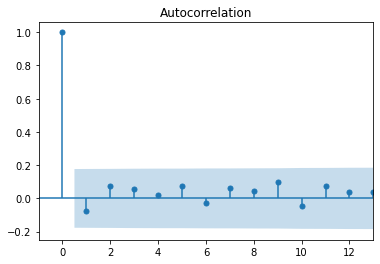

In [18]:
tsaplots.plot_acf(train_res_arima.resid)
plt.xlim(-1, 13)
plt.show()

## Table 17.8

In [19]:
sp500_df = dmba.load_data('SP500.csv')
# convert date to first of each month
sp500_df['Date'] = pd.to_datetime(sp500_df.Date, format='%d-%b-%y').dt.to_period('M')
sp500_ts = pd.Series(sp500_df.Close.values, index=sp500_df.Date, name='sp500')
sp500_arima = ARIMA(sp500_ts, order=(1, 0, 0)).fit(disp=0)
print(pd.DataFrame({'coef': sp500_arima.params, 'std err': sp500_arima.bse}))

                   coef     std err
const        888.534652  221.785817
ar.L1.sp500    0.983373    0.014523


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
